
# Balanced CNN Benchmark (PyTorch Only): ResNet-101 & EfficientNet-B5
*Created:* 2025-09-25 06:23

This notebook demonstrates a **trim + augmentation balancing pipeline** for knee imaging classification.  
We evaluate two models using PyTorch only:

- **ResNet-101**
- **ResNet-18**

Both are trained end-to-end with class balancing via trimming and augmentation.  
Finally, we collapse the dataset into **3 super-classes** and repeat the experiments.

---

### Key Details:
- **Trim parameters hard-coded**:  
  - `max_samples = 500`  
  - `min_samples = 173`  
  - `n = 500` (balanced per class after augmentation)  
- **Balanced datasets saved** to new folders (`./balanced_data/`, `./balanced_data_3class/`)  
- **Evaluation**: Training/validation curves, confusion matrix with per-class %, and macro precision/recall/F1.  
- **Image previews**: Show trimmed and balanced samples per class.

---


## 1) Setup & Configuration

In [1]:

import os, shutil, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

# Global config
ORIG_DATA_DIR = "Data/train"
BAL_DIR = "./balanced_data"
BAL_DIR_3 = "./balanced_data_3class"

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Trim/balance params
MAX_SAMPLES = 500
MIN_SAMPLES = 173
BALANCE_N = 500

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

## 2) Trim & Balance Functions

In [2]:

def trim(df, max_samples, min_samples, column):
    df=df.copy()
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('After trimming: max=',max_samples, ', min=', min_samples)
    return trimmed_df

def augment_and_save(df, n, out_dir, img_size):
    if os.path.exists(out_dir):
        shutil.rmtree(out_dir)
    os.makedirs(out_dir, exist_ok=True)

    aug_tfms = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomResizedCrop(img_size, scale=(0.8,1.0)),
        transforms.ToTensor()
    ])

    to_pil = transforms.ToPILImage()

    groups = df.groupby('labels')
    balanced_records = []
    for label in df['labels'].unique():
        group = groups.get_group(label)
        paths = group['filepaths'].tolist()
        count = len(paths)

        class_dir = os.path.join(out_dir, label)
        os.makedirs(class_dir, exist_ok=True)

        # Copy originals
        for fp in paths:
            fname = os.path.basename(fp)
            new_path = os.path.join(class_dir, fname)
            shutil.copy(fp, new_path)
            balanced_records.append((new_path, label))

        # Augment if needed
        if count < n:
            delta = n - count
            print(f"Augmenting {label}: {delta} images")
            for i in range(delta):
                img = Image.open(random.choice(paths)).convert("RGB")
                aug_img = aug_tfms(img)
                aug_img_pil = to_pil(aug_img)
                aug_path = os.path.join(class_dir, f"aug_{i}.jpg")
                aug_img_pil.save(aug_path)
                balanced_records.append((aug_path, label))

    balanced_df = pd.DataFrame(balanced_records, columns=["filepaths","labels"])
    print("Final balanced counts:\n", balanced_df['labels'].value_counts())
    return balanced_df


## 3) Visualize Trimmed & Balanced Data

Original counts:
 labels
0    2286
2    1516
1    1046
3     757
4     173
Name: count, dtype: int64
After trimming: max= 500 , min= 173
Augmenting 4: 327 images
Final balanced counts:
 labels
0    500
1    500
2    500
3    500
4    500
Name: count, dtype: int64


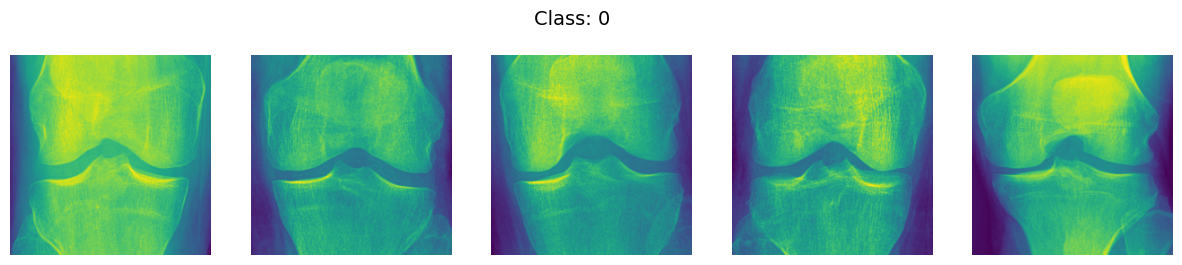

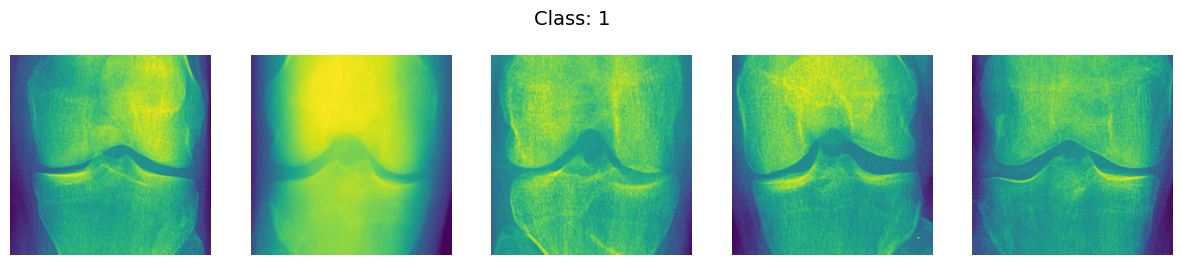

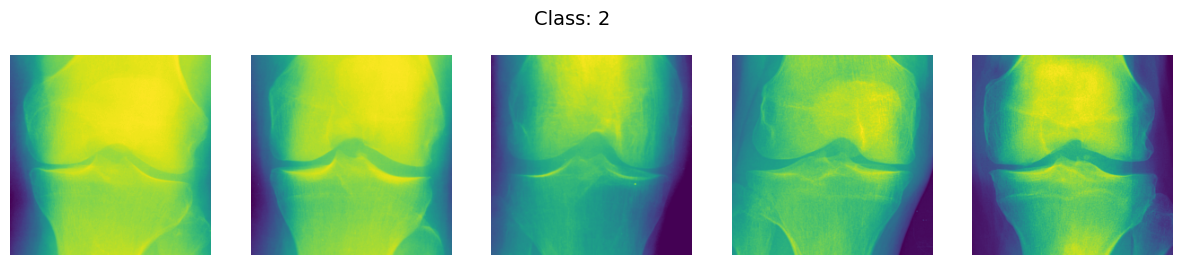

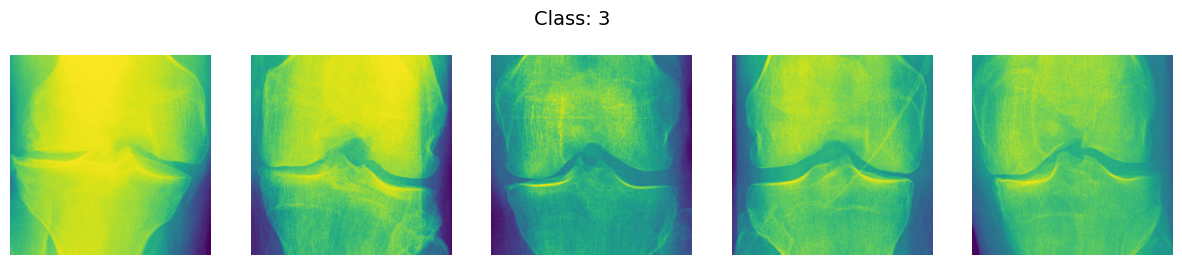

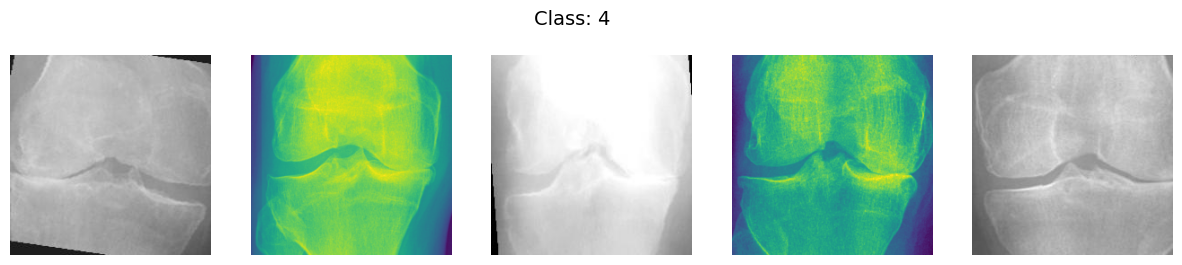

In [3]:

def show_samples(df, n=5):
    classes = df['labels'].unique()
    for label in classes:
        sample_paths = df[df['labels']==label]['filepaths'].sample(n=min(n, len(df))).tolist()
        fig, axes = plt.subplots(1, len(sample_paths), figsize=(15,3))
        fig.suptitle(f"Class: {label}", fontsize=14)
        for ax, path in zip(axes, sample_paths):
            img = Image.open(path)
            ax.imshow(img)
            ax.axis("off")
        plt.show()

# Build dataframe from original dataset
filepaths, labels = [], []
for label in os.listdir(ORIG_DATA_DIR):
    class_dir = os.path.join(ORIG_DATA_DIR, label)
    for f in os.listdir(class_dir):
        filepaths.append(os.path.join(class_dir, f))
        labels.append(label)
train_df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

print("Original counts:\n", train_df['labels'].value_counts())

# Trim and balance
train_df = trim(train_df, MAX_SAMPLES, MIN_SAMPLES, 'labels')
train_df = augment_and_save(train_df, BALANCE_N, BAL_DIR, IMG_SIZE)

# Show samples after balancing
show_samples(train_df, n=5)


## 4) PyTorch Dataset & Dataloaders

In [4]:

class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.classes = sorted(self.df['labels'].unique())
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'filepaths']
        label = self.df.loc[idx, 'labels']
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.class_to_idx[label]

train_tfms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_dataset = CustomDataset(train_df, transform=train_tfms)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


## 5) Training Utilities

In [5]:

def train_model(model, loader, epochs=5, lr=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses, accs = [], []
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0,0,0
        for x,y in loader:
            x,y=x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs,y)
            loss.backward(); optimizer.step()
            running_loss += loss.item()*x.size(0)
            _,preds = outputs.max(1)
            correct += preds.eq(y).sum().item(); total+=y.size(0)
        losses.append(running_loss/total)
        accs.append(correct/total)
        print(f"Epoch {epoch+1}: Loss {losses[-1]:.4f}, Acc {accs[-1]:.4f}")
    return losses, accs

def plot_curves(losses, accs, title):
    plt.figure(figsize=(8,4))
    plt.plot(losses,label="Loss")
    plt.plot(accs,label="Accuracy")
    plt.title(title)
    plt.legend(); plt.show()


## 6) ResNet-101 Training

c:\Projects\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Projects\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Loss 1.0944, Acc 0.5088
Epoch 2: Loss 0.8199, Acc 0.6404
Epoch 3: Loss 0.6514, Acc 0.7164
Epoch 4: Loss 0.5119, Acc 0.7988
Epoch 5: Loss 0.3587, Acc 0.8624
Epoch 6: Loss 0.2299, Acc 0.9152
Epoch 7: Loss 0.1716, Acc 0.9428
Epoch 8: Loss 0.1378, Acc 0.9596
Epoch 9: Loss 0.1063, Acc 0.9636
Epoch 10: Loss 0.1034, Acc 0.9636
Epoch 11: Loss 0.1010, Acc 0.9672
Epoch 12: Loss 0.0826, Acc 0.9724
Epoch 13: Loss 0.0608, Acc 0.9796
Epoch 14: Loss 0.0570, Acc 0.9808
Epoch 15: Loss 0.0796, Acc 0.9736
Epoch 16: Loss 0.0628, Acc 0.9816
Epoch 17: Loss 0.0936, Acc 0.9668
Epoch 18: Loss 0.0576, Acc 0.9808
Epoch 19: Loss 0.0771, Acc 0.9732
Epoch 20: Loss 0.0607, Acc 0.9812
Epoch 21: Loss 0.0372, Acc 0.9884
Epoch 22: Loss 0.0289, Acc 0.9892
Epoch 23: Loss 0.0231, Acc 0.9916
Epoch 24: Loss 0.0206, Acc 0.9932
Epoch 25: Loss 0.0228, Acc 0.9936
Epoch 26: Loss 0.0735, Acc 0.9772
Epoch 27: Loss 0.0392, Acc 0.9856
Epoch 28: Loss 0.1114, Acc 0.9612
Epoch 29: Loss 0.0604, Acc 0.9820
Epoch 30: Loss 0.0264, 

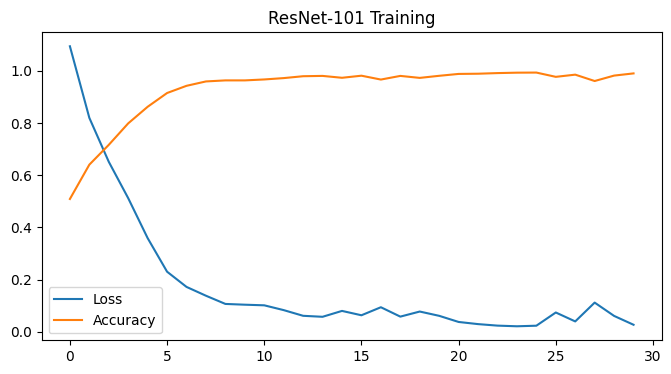

In [6]:

model_resnet = models.resnet101(pretrained=True)
in_feats = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(in_feats, len(train_dataset.classes))
model_resnet = model_resnet.to(DEVICE)

losses, accs = train_model(model_resnet, train_loader, epochs=30)
plot_curves(losses, accs, "ResNet-101 Training")


In [13]:
# Save ResNet-101
torch.save({
    'model_state_dict': model_resnet.state_dict(),
    'class_to_idx': train_dataset.class_to_idx
}, "resnet101_model.pth")

## 7) Resnet-50 Training

Epoch 1: Loss 1.1071, Acc 0.4952
Epoch 2: Loss 0.7742, Acc 0.6660
Epoch 3: Loss 0.5774, Acc 0.7544
Epoch 4: Loss 0.4410, Acc 0.8272
Epoch 5: Loss 0.3115, Acc 0.8856
Epoch 6: Loss 0.2077, Acc 0.9236
Epoch 7: Loss 0.1488, Acc 0.9492
Epoch 8: Loss 0.1041, Acc 0.9636
Epoch 9: Loss 0.0867, Acc 0.9724
Epoch 10: Loss 0.0965, Acc 0.9636
Epoch 11: Loss 0.0681, Acc 0.9764
Epoch 12: Loss 0.0680, Acc 0.9800
Epoch 13: Loss 0.1080, Acc 0.9688
Epoch 14: Loss 0.0658, Acc 0.9776
Epoch 15: Loss 0.0601, Acc 0.9784
Epoch 16: Loss 0.0537, Acc 0.9816
Epoch 17: Loss 0.0578, Acc 0.9820
Epoch 18: Loss 0.0953, Acc 0.9688
Epoch 19: Loss 0.0475, Acc 0.9860
Epoch 20: Loss 0.0547, Acc 0.9804
Epoch 21: Loss 0.0480, Acc 0.9836
Epoch 22: Loss 0.0606, Acc 0.9820
Epoch 23: Loss 0.0371, Acc 0.9896
Epoch 24: Loss 0.0253, Acc 0.9904
Epoch 25: Loss 0.0323, Acc 0.9900
Epoch 26: Loss 0.0198, Acc 0.9940
Epoch 27: Loss 0.0422, Acc 0.9864
Epoch 28: Loss 0.1031, Acc 0.9700
Epoch 29: Loss 0.0522, Acc 0.9836
Epoch 30: Loss 0.0623, 

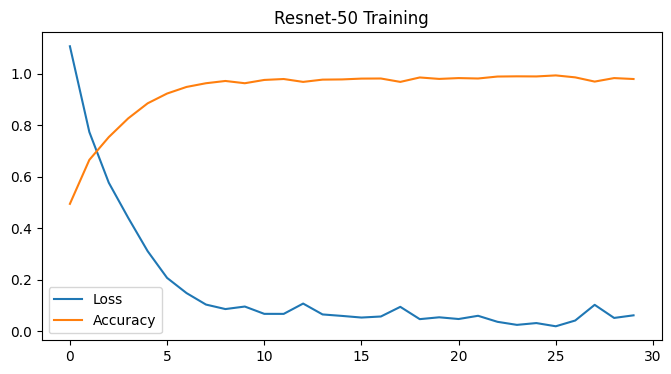

In [7]:
model_eff = models.resnet50(weights='IMAGENET1K_V1')
in_feats = model_eff.fc.in_features
model_eff.fc = nn.Linear(in_feats, len(train_dataset.classes))
model_eff = model_eff.to(DEVICE)

losses, accs = train_model(model_eff, train_loader, epochs=30)
plot_curves(losses, accs, "Resnet-50 Training")

In [12]:
# Save ResNet-50
torch.save({
    'model_state_dict': model_eff.state_dict(),
    'class_to_idx': train_dataset.class_to_idx
}, "resnet50_model.pth")

print("Models saved successfully!")

Models saved successfully!


## 8) Evaluation Utilities

In [10]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns

def evaluate_model(model, loader, class_names, model_name="Model"):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(DEVICE), y.to(DEVICE)
            outputs = model(x)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm_percent = cm.astype(float) / cm.sum(axis=1)[:, None] * 100

    plt.figure(figsize=(8,6))
    sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{model_name} - Confusion Matrix (%)")
    plt.show()

    # Classification Report
    print(f"\n===== {model_name} Report =====\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Macro metrics
    p, r, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro", zero_division=0)
    print(f"Macro Precision: {p:.4f}")
    print(f"Macro Recall:    {r:.4f}")
    print(f"Macro F1:        {f1:.4f}")

    # Per-class accuracy
    correct_per_class = cm.diagonal()
    total_per_class = cm.sum(axis=1)
    acc_per_class = correct_per_class / total_per_class

    plt.figure(figsize=(10,5))
    sns.barplot(x=class_names, y=acc_per_class*100)
    plt.title(f"{model_name} - Per Class Accuracy (%)")
    plt.ylabel("Accuracy (%)")
    plt.xticks(rotation=45)
    plt.ylim(0,100)
    plt.show()

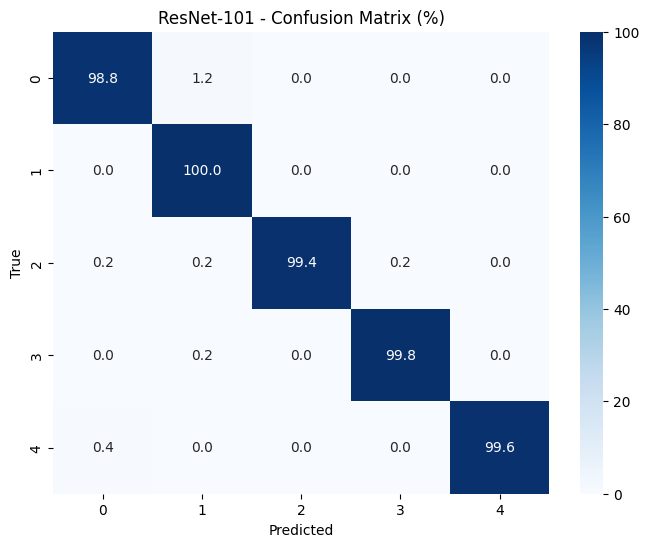


===== ResNet-101 Report =====

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       500
           1       0.98      1.00      0.99       500
           2       1.00      0.99      1.00       500
           3       1.00      1.00      1.00       500
           4       1.00      1.00      1.00       500

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500

Macro Precision: 0.9952
Macro Recall:    0.9952
Macro F1:        0.9952


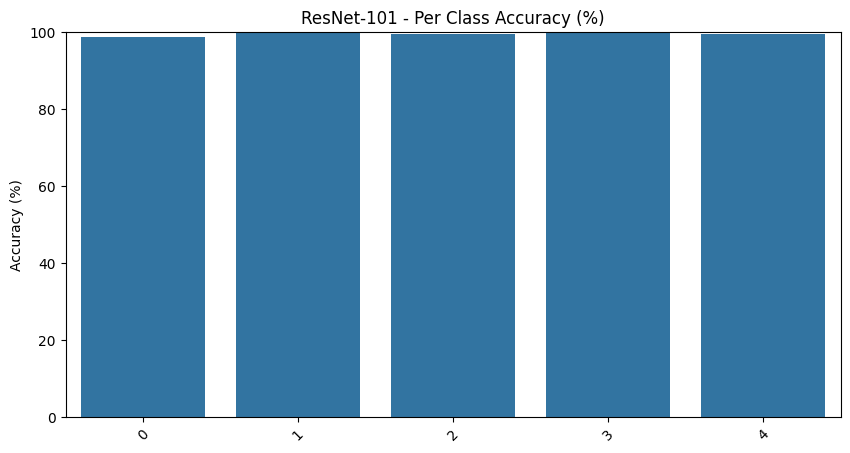

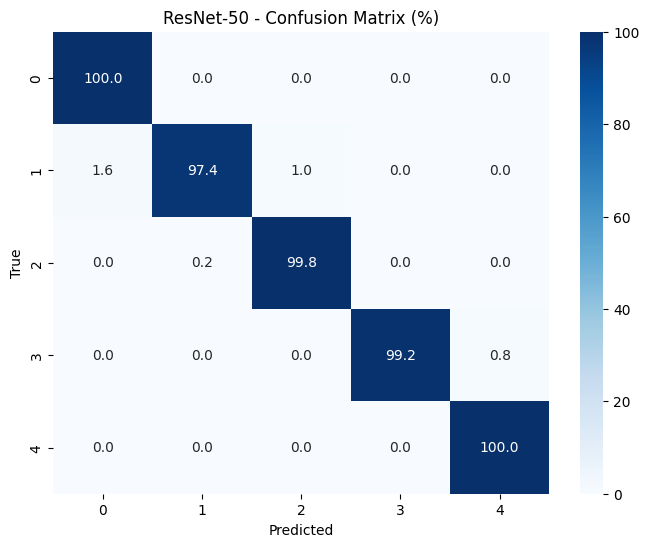


===== ResNet-50 Report =====

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       500
           1       1.00      0.97      0.99       500
           2       0.99      1.00      0.99       500
           3       1.00      0.99      1.00       500
           4       0.99      1.00      1.00       500

    accuracy                           0.99      2500
   macro avg       0.99      0.99      0.99      2500
weighted avg       0.99      0.99      0.99      2500

Macro Precision: 0.9929
Macro Recall:    0.9928
Macro F1:        0.9928


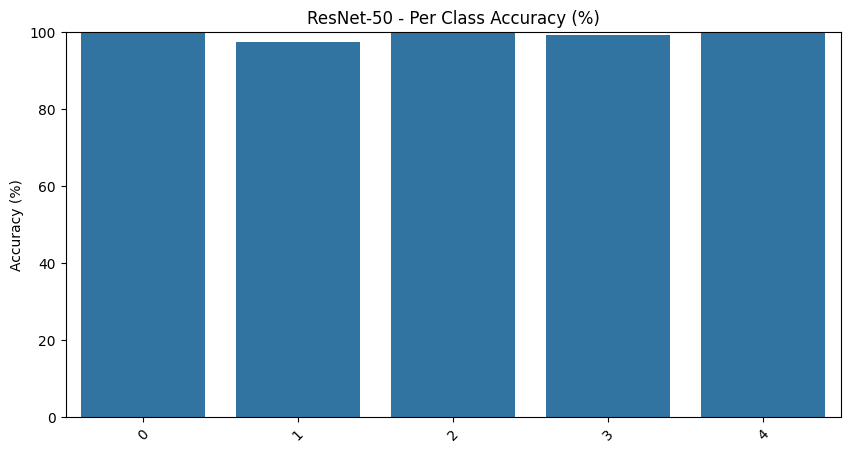

In [14]:
# Get class names from your training dataset
class_names = train_dataset.classes

#Evaluate ResNet-101
evaluate_model(model_resnet, train_loader, class_names, model_name="ResNet-101")

#Evaluate ResNet-50
evaluate_model(model_eff, train_loader, class_names, model_name="ResNet-50")